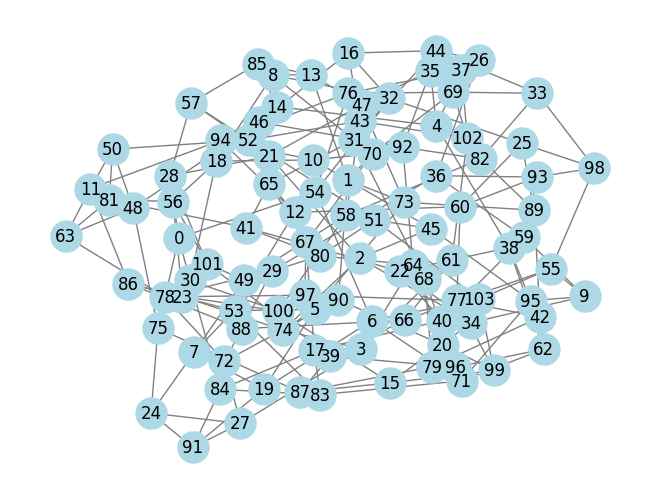

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Parameters
k = 4  # Degree of each node
n = 104  # Number of nodes

# Generate k-regular graph
G = nx.random_regular_graph(k, n)

# Draw the graph
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
plt.show()


In [26]:
binary_vectors = [[False] * G.number_of_nodes() for i in range(G.number_of_edges())]

# Fill the binary matrix
for i, (u, v) in enumerate(G.edges):
    binary_vectors[i][u] = True  # Mark the first node of the edge
    binary_vectors[i][v] = True   # Mark the second node of the edge

In [27]:
import json

with open("MaxCut/"+"Regular"+ str(n) +"_"+ str(k) +".json", "w") as f:
    json.dump(binary_vectors, f)

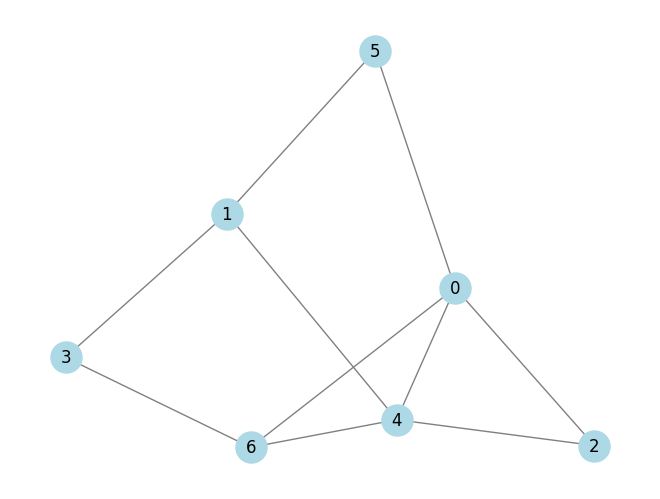

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

n = 7  # Number of nodes
p = 0.3  # Probability of edge creation

G = nx.erdos_renyi_graph(n, p)

# Draw graph
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
plt.show()


In [36]:
binary_vectors = [[False] * G.number_of_nodes() for i in range(G.number_of_edges())]

# Fill the binary matrix
for i, (u, v) in enumerate(G.edges):
    binary_vectors[i][u] = True  # Mark the first node of the edge
    binary_vectors[i][v] = True   # Mark the second node of the edge

In [37]:
import json

with open("MaxCut/"+"Random"+ str(n) +"_"+ str(G.number_of_edges()) +".json", "w") as f:
    json.dump(binary_vectors, f)

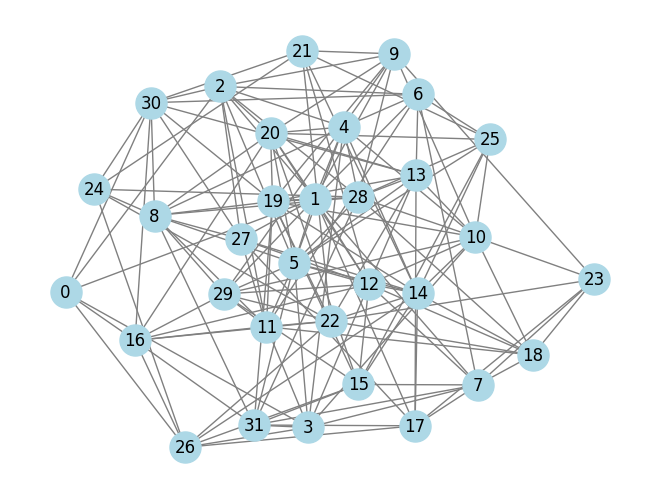

In [63]:
n = 32
m = 157
G3 = nx.gnm_random_graph(n, m)

nx.draw(G3, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
plt.show()

In [64]:
binary_vectors = [[False] * G3.number_of_nodes() for i in range(G3.number_of_edges())]

# Fill the binary matrix
for i, (u, v) in enumerate(G3.edges):
    binary_vectors[i][u] = True  # Mark the first node of the edge
    binary_vectors[i][v] = True   # Mark the second node of the edge

In [65]:
import json

with open("MaxCut/"+"Random"+ str(n) +"_"+ str(G3.number_of_edges()) +".json", "w") as f:
    json.dump(binary_vectors, f)

### Qiskit transpile

In [80]:
import json
import numpy as np
# Read from JSON file
num_qubit = 104  # Length of each vector
k = 4  # Max True values allowed per vector
with open("MaxCut/"+"Regular"+ str(num_qubit) +"_"+ str(k) +".json", "r") as file:
    boolean_functions = json.load(file)

F = []
one_term_boolean_functions = []
for f in boolean_functions:
    if sum(f)==0:
        print("Incorrect! Containing all False boolean function")
        break
    if sum(f)==1:
        one_term_boolean_functions.append(f)
    if sum(f)>1:
        F.append(f)

In [81]:
import numpy as np

def hamming_distance(vec1, vec2):
    """
    Computes the Hamming distance between two binary vectors.
    
    :param vec1: First binary vector (list of 0/1 or True/False)
    :param vec2: Second binary vector (list of 0/1 or True/False)
    :return: Integer Hamming distance
    """
    return sum(a != b for a, b in zip(vec1, vec2))

def select_best_vector(reference_list, candidate_list):
    """
    Selects the vector from candidate_list that has the minimum total Hamming weight 
    with respect to all vectors in reference_list.
    
    :param reference_list: List of binary vectors (comparison base)
    :param candidate_list: List of binary vectors (selection pool)
    :return: The best binary vector from candidate_list
    """
    best_vector = None
    min_hamming_sum = float('inf')

    for candidate in candidate_list:
        total_hamming = sum(hamming_distance(candidate, ref) for ref in reference_list)
        
        if total_hamming < min_hamming_sum:
            min_hamming_sum = total_hamming
            best_vector = candidate

    return best_vector

ordered_F = []
candidate_F = [f for f in F]
while candidate_F:
    # Select the best vector
    best_vector = select_best_vector(ordered_F, candidate_F)
    ordered_F.append(best_vector)
    candidate_F.remove(best_vector)

In [18]:
import os
import sys

here = os.path.dirname('Benchmark.ipynb')

sys.path.append(os.path.join(here, '..'))

In [83]:
from QAOA_benchmark import boolean_func_to_normal_qaoa_circuit
import time
start_time = time.time()
org_qc, theta_2 = boolean_func_to_normal_qaoa_circuit(ordered_F,1)

parameter_values = [np.pi/5, np.pi/4]
parameter_dict = {param: value for param, value in zip(theta_2, parameter_values)}

# Bind the parameters
bound_org_qc = org_qc.assign_parameters(parameter_dict)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3)
candidate_circuit = pm.run(bound_org_qc)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.17441773414611816


In [84]:
candidate_circuit.count_ops()

OrderedDict([('cx', 416), ('rz', 208), ('h', 104), ('rx', 104)])

In [85]:
candidate_circuit.depth()

293

In [86]:
from qiskit import QuantumCircuit, qpy
path = '/Users/xinpengli/Desktop/QAOAZ3/'
with open(path+"Experiment/MaxCut/logical/"+"Regular"+ str(num_qubit) +"_"+ str(k) +"_logical_circuit.qpy", "wb") as qpy_file_write:
    qpy.dump(candidate_circuit, qpy_file_write)

#### For qiskit compile

In [ ]:
from qiskit import QuantumCircuit, qpy
num_qubit = 24  # Length of each vector
k = 8  # Max True values allowed per vector
path = '/Users/xinpengli/Desktop/QAOAZ3/'
with open(path+"Experiment/MaxCut/logical/"+"Regular"+ str(num_qubit) +"_"+ str(k) +"_logical_circuit.qpy", "rb") as f:
    bound_org_qc_list = qpy.load(f)
    candidate_circuit = bound_org_qc_list[0]

In [22]:
from qiskit_util import  remove_unused_qubit, Fake127_transpile
import time
start_time = time.time()
transpiled_bound_org_qc,subcoupling_map = Fake127_transpile(candidate_circuit, basis_gate=False)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

operator count:  OrderedDict([('cx', 192), ('swap', 146), ('rz', 96), ('h', 24), ('rx', 24)])
depth:  260
0.06868290901184082


In [11]:
# from qiskit_util import swap_to_cnot
def swap_to_cnot(qc):
    new_qc = QuantumCircuit(qc.qubits, qc.clbits)
    for gate in qc.data:
        if gate.name == 'swap':
            new_qc.cx(gate.qubits[0], gate.qubits[1])
            new_qc.cx(gate.qubits[1], gate.qubits[0])
            new_qc.cx(gate.qubits[0], gate.qubits[1])
        else:
            new_qc.append(gate)
    return new_qc
no_swap_recovered_transpiled_bound_org_qc  = swap_to_cnot(transpiled_bound_org_qc)

In [12]:
no_swap_recovered_transpiled_bound_org_qc.depth()

814

In [13]:
no_swap_recovered_transpiled_bound_org_qc.count_ops()

OrderedDict([('cx', 2066), ('rz', 160), ('h', 80), ('rx', 80)])

In [14]:
from qiskit import QuantumCircuit, qpy
import json
with open(path+"Experiment/MaxCut/qiskit/"+"Regular"+ str(num_qubit) +"_"+ str(k) +"_qiskit_circuit.qpy", "wb") as qpy_file_write:
    qpy.dump(transpiled_bound_org_qc, qpy_file_write)

with open(path+"Benchmark/MaxCut_layout/"+"Regular"+ str(num_qubit) +"_"+ str(k) +"_IBM_127.json", "w") as f:
    json.dump(subcoupling_map, f)